In [2]:
import pathlib
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad

def read_anndata(folder: str):
    adata = sc.read_h5ad(f"/oak/stanford/projects/kibr/Reorganizing/Projects/James/lipid-droplet-gcn/data/lipid-droplet/{folder}.h5ad")
    adata.obsm["explanation"] = pd.read_csv(f"/oak/stanford/projects/kibr/Reorganizing/Projects/James/lipid-droplet-gcn/data/captum-lipid-droplet/{folder}.csv").set_index("cell_id")
    return adata

adata = {
    folder: read_anndata(folder) 
    for folder in [x.name[:-5] for x in 
    pathlib.Path("/oak/stanford/projects/kibr/Reorganizing/Projects/James/lipid-droplet-gcn/data/lipid-droplet").glob('*.h5ad')]
}

adata = ad.concat(adata, label="folder")

/oak/stanford/projects/kibr/Reorganizing/Projects/James/lipid-droplet-gcn/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Question

Given neurons that appear to have oxidative cell stress, do astrocytes tend to accumulate more and larger lipid droplets, indicative of a transfer mechanism from neurons to astrocytes.

In [35]:
import torch
subset = adata[adata.obs["cell_type"].eq("L2/3 IT") & adata.obs["folder"].eq("05-27")]


tensor([[4116.7549, 1681.3853],
        [4145.8262, 1695.6470],
        [4135.8486, 1715.1497],
        ...,
        [8596.0566, 4436.1582],
        [8610.9502, 4432.4346],
        [8774.8877, 4359.7559]], dtype=torch.float64)

In [138]:
coordinates = torch.tensor(subset.obs[["x_centroid", "y_centroid"]].values).float()
counts = torch.tensor(subset.layers["transcript"]).float()
size_factor = torch.log(counts.sum(axis=1) / counts.sum(axis=1).mean()).float()
coordinates = 


In [141]:
import torch
import pyro
import pyro.distributions as dist
from pyro.nn.module import PyroSample
from pyro.contrib.gp.kernels import Matern52
from pyro.contrib.gp.models import VariationalGP
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch.distributions import constraints
from pyro.contrib.gp.kernels import Matern52
from pyro.contrib.gp.models import VariationalGP, VariationalSparseGP
import pyro
import torch
from torch.distributions import constraints
from sklearn.cluster import KMeans

# Fix seed
pyro.set_rng_seed(0)
pyro.clear_param_store()


kmeans = KMeans(n_clusters=100).fit(coordinates.numpy())
inducing_inputs = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

kernel = Matern52(input_dim=2)
kernel.lengthscale = pyro.param("lengthscale", torch.tensor(1.0), constraint=constraints.positive)
kernel.variance = pyro.param("variance", torch.tensor(1.0), constraint=constraints.positive)

model = VariationalSparseGP(
    coordinates,               # training inputs
    None,            # no training targets here — handled in your model_fn
    kernel,
    Xu=inducing_inputs,      # inducing locations
    likelihood=None,         # custom NB likelihood
    latent_shape=torch.Size([1]),
    whiten=True,
    jitter=1e-3
)

def model_fn(coordinates, counts, size_factor):
    r = pyro.param("r", torch.tensor(1.0), constraint=constraints.positive)

    f_loc, f_var = model(coordinates)
    pyro.sample("counts", dist.NegativeBinomial(total_count=r, logits=f_loc).to_event(1), obs=counts)

def guide_fn(coordinates, counts, size_factor):
    return model.guide()

optimizer = Adam({"lr": 0.001})
svi = SVI(model_fn, guide_fn, optimizer, loss=Trace_ELBO())

num_steps = 1_200
for i in range(num_steps):
    loss = svi.step(coordinates, counts[:, 0], size_factor)
    if i % 10 == 0:
        print(f"[{i}] ELBO: {-loss:.2f} | r={pyro.param('r').item():.3f}")

f_post_mean, _ = model(coordinates)

/oak/stanford/projects/kibr/Reorganizing/Projects/James/lipid-droplet-gcn/.venv/lib/python3.12/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(


[0] ELBO: -3511.22 | r=0.999
[10] ELBO: -3436.23 | r=0.989
[20] ELBO: -3356.68 | r=0.979
[30] ELBO: -3295.42 | r=0.970
[40] ELBO: -3213.79 | r=0.960
[50] ELBO: -3127.13 | r=0.951
[60] ELBO: -3032.45 | r=0.942
[70] ELBO: -2962.25 | r=0.933
[80] ELBO: -2882.60 | r=0.925
[90] ELBO: -2783.99 | r=0.916
[100] ELBO: -2697.90 | r=0.908
[110] ELBO: -2612.57 | r=0.900
[120] ELBO: -2510.09 | r=0.893
[130] ELBO: -2420.18 | r=0.885
[140] ELBO: -2321.54 | r=0.878
[150] ELBO: -2238.00 | r=0.871
[160] ELBO: -2132.45 | r=0.864
[170] ELBO: -2040.74 | r=0.858
[180] ELBO: -1938.31 | r=0.852
[190] ELBO: -1841.10 | r=0.846
[200] ELBO: -1754.04 | r=0.840
[210] ELBO: -1656.05 | r=0.835
[220] ELBO: -1568.28 | r=0.830
[230] ELBO: -1502.80 | r=0.825
[240] ELBO: -1413.45 | r=0.821
[250] ELBO: -1345.79 | r=0.816
[260] ELBO: -1272.77 | r=0.812
[270] ELBO: -1195.10 | r=0.809
[280] ELBO: -1137.37 | r=0.805
[290] ELBO: -1095.96 | r=0.802
[300] ELBO: -1041.98 | r=0.798
[310] ELBO: -994.63 | r=0.795
[320] ELBO: -947.74 

KeyboardInterrupt: 

In [167]:
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.nn.module import PyroSample
from pyro.contrib.gp.kernels import Matern52
from pyro.contrib.gp.models import VariationalSparseGP
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.cluster import KMeans

class SpatialNegativeBinomialGP:
    def __init__(self, coordinates, counts, size_factor, num_inducing=100, learning_rate=1e-3, jitter=1e-3, seed=0):
        self.coordinates = coordinates
        self.counts = counts
        self.size_factor = size_factor
        self.num_inducing = num_inducing
        self.learning_rate = learning_rate
        self.jitter = jitter

        # Init randomness
        pyro.set_rng_seed(seed)
        pyro.clear_param_store()

        # Inducing inputs via KMeans
        self.inducing_inputs = self._init_inducing_inputs()

        # Kernel setup
        self.kernel = Matern52(input_dim=coordinates.size(1))
        self.kernel.lengthscale = pyro.param("lengthscale", torch.tensor(1.0), constraint=constraints.positive)
        self.kernel.variance = pyro.param("variance", torch.tensor(1.0), constraint=constraints.positive)

        # GP model
        self.model = VariationalSparseGP(
            X=self.coordinates,
            y=None,
            kernel=self.kernel,
            Xu=self.inducing_inputs,
            likelihood=None,
            latent_shape=torch.Size([1]),
            whiten=True,
            jitter=self.jitter,
        )

        # Optimizer + SVI
        self.optimizer = Adam({"lr": self.learning_rate})
        self.svi = SVI(self.model_fn, self.guide_fn, self.optimizer, loss=Trace_ELBO())

    def _init_inducing_inputs(self):
        kmeans = KMeans(n_clusters=self.num_inducing).fit(self.coordinates.detach().cpu().numpy())
        return torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, device=self.coordinates.device)

    def model_fn(self, coordinates, counts):
        r = pyro.param("r", torch.tensor(1.0), constraint=constraints.positive)
        f_loc, _ = self.model(coordinates)
        f_loc = torch.clamp(f_loc, -10, 10)
        pyro.sample("counts", dist.NegativeBinomial(total_count=r, logits=self.size_factor + f_loc).to_event(1), obs=counts)

    def guide_fn(self, coordinates, counts):
        return self.model.guide()

    def train(self, num_steps=1000, verbose=True):
        for i in range(num_steps):
            loss = self.svi.step(self.coordinates, self.counts)
            if verbose and i % 10 == 0:
                r_val = pyro.param("r").item()
                print(f"[{i}] ELBO: {-loss:.2f} | r={r_val:.3f}")

    def predict(self, Xnew=None):
        Xnew = self.coordinates if Xnew is None else Xnew
        with torch.no_grad():
            f_loc, f_var = self.model(Xnew)
            return f_loc, f_var

    def get_dispersion(self):
        return pyro.param("r").item()

    def get_kernel_params(self):
        return {
            "lengthscale": self.kernel.lengthscale.item(),
            "variance": self.kernel.variance.item(),
        }


In [168]:
snbgp = SpatialNegativeBinomialGP(coordinates=coordinates, counts=counts[:, 0], size_factor=size_factor)
snbgp.train()

/oak/stanford/projects/kibr/Reorganizing/Projects/James/lipid-droplet-gcn/.venv/lib/python3.12/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'u'}
  warnings.warn(


[0] ELBO: -3108.41 | r=0.999
[10] ELBO: -3043.86 | r=0.989
[20] ELBO: -2974.79 | r=0.979
[30] ELBO: -2924.09 | r=0.970
[40] ELBO: -2853.14 | r=0.960
[50] ELBO: -2777.30 | r=0.951
[60] ELBO: -2693.61 | r=0.942
[70] ELBO: -2634.49 | r=0.933
[80] ELBO: -2566.07 | r=0.925
[90] ELBO: -2479.17 | r=0.916
[100] ELBO: -2405.46 | r=0.908
[110] ELBO: -2333.14 | r=0.900
[120] ELBO: -2243.97 | r=0.892
[130] ELBO: -2167.52 | r=0.885
[140] ELBO: -2082.55 | r=0.878
[150] ELBO: -2012.72 | r=0.871
[160] ELBO: -1920.85 | r=0.864
[170] ELBO: -1841.80 | r=0.858
[180] ELBO: -1750.21 | r=0.851
[190] ELBO: -1662.55 | r=0.846
[200] ELBO: -1584.19 | r=0.840
[210] ELBO: -1494.25 | r=0.835
[220] ELBO: -1414.58 | r=0.829
[230] ELBO: -1358.00 | r=0.825
[240] ELBO: -1278.27 | r=0.820
[250] ELBO: -1219.89 | r=0.816
[260] ELBO: -1155.61 | r=0.812
[270] ELBO: -1086.79 | r=0.808
[280] ELBO: -1036.97 | r=0.804
[290] ELBO: -1001.85 | r=0.801
[300] ELBO: -952.95 | r=0.797
[310] ELBO: -909.68 | r=0.794
[320] ELBO: -866.01 |

In [164]:
subset.obs["logits"] = snbgp.predict()[0].detach().numpy().reshape(-1, 1)

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

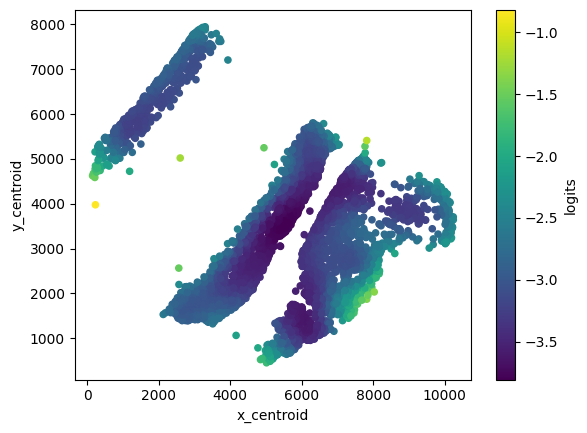

In [166]:
subset.obs.plot.scatter(x="x_centroid", y="y_centroid", c="logits")